# Brief Overview on How to Use the MultiViz Analytics Engine (MVG) Library

## Introduction

The MultiViz Analytics Engine (MVG) Library is a Python library that enables the use of
Viking Analytics's MVG Analytics Service.
To access this service, Viking Analytics (VA) provides a REST API towards its analytics server.
The simplification of access to this service is enabled by the VA-MVG Python package,
which allows interaction with the service via regular python calls.

This interactive document shall show the whole flow working with the service from
Python, from data upload to retrieval of analysis results for the analysis of vibration signals.

### Signing up for the service

For commercial use of the service, you will need to acquire a token from Viking Analytics.
For the example here, we use a built-in token for demo.
Please contact us for a free trial and provide you with your token.


### Python Pre-requisites

1. Make sure you have Python 3.6 or higher installed.

In the following section we will walk through the code needed for the API interaction

## Imports

First, we begin with the general imports of Python libraries that are needed as part of this project.

In [1]:
import json
import os
import sys
from pathlib import Path

from tqdm.notebook import tqdm
import pandas as pd
from requests import HTTPError

We proceed by installing the MVG library in our project.

In [ ]:
!{sys.executable} -m pip install va-mvg

We follow by importing the MVG library.

The library documentation is available at [https://vikinganalytics.github.io/mvg/index.html](https://vikinganalytics.github.io/mvg/index.html).

In [2]:
from mvg import MVG

We begin by instantiating a "session" object with the MVG library.
A session object basically caches the endpoint and the token, to simplify the calls to the MVG library.

NOTE: Each TOKEN is used for Authorization AND Authentication.
Thus, each unique token represents a unique user, each user has it own, unique database on the VA-MVG' service.

In [3]:
ENDPOINT = "https://api.beta.multiviz.com"
# Replace by your own Token
VALID_TOKEN = os.environ['TEST_TOKEN']

In [4]:
session = MVG(ENDPOINT, VALID_TOKEN)

We now check if the server is alive.
The hello message contains the API version:

In [5]:
session.say_hello()

{'api': {'name': 'MultiViz Engine API',
  'version': '0.0.0-dev0',
  'swagger': 'http://localhost:8000/docs'}}

## Sources and Measurements

Before we begin, we will ensure there are no previously existing sources and if there are, we will delete them.

In [6]:
sources = session.list_sources()

for src in sources:
    print(f"Deleting {src['source_id']}")
    session.delete_source(src['source_id'])

Deleting u0001


The example below revolves around a sources with source_id "u0001".

For convenience, this source and its measurements are available with the package distribution.

You can retrieve the data from our public charlie repo https://github.com/vikinganalytics/va-data-charlie.git

In [ ]:
!git clone --depth=1 https://github.com/vikinganalytics/va-data-charlie.git

In [7]:
# Path to the source folder
REF_DB_PATH = Path.cwd() / "va-data-charlie" / "charlieDb" / "acc"
REF_DB_PATH
# Definition of the source_id
SOURCE_ID = "u0001"
SOURCE_ID


'u0001'

### Creating a Source

A source represents a vibration data source, typically a vibration sensor.
Internally, in the analytics engine and data storage, all vibration data is stored under its source. 
In essence, a source is an identifier formed by
 - the source ID
 - metadata with required fields
 - optional arbitrary customer specific 'free form' data belonging to the source.
 
The vibration service will only rely on the required fields.
The free form data is a possibility for the client side to keep together source information, measurements and metadata which may be interesting for the analytics built-in features in the service.
Examples of the free form data include location of sensor or the name of the asset which is mounted on.
As we will see later, timestamps are internally represented as milliseconds since EPOCH (Jan 1st 1970), for that reason it is good practice to include the timezone where the measurement originated in the metadata.

In [8]:
meta_information = {'assetId': 'assetJ', 'measPoint': 'mloc01', 'location': 'cancun', 'timezone': 'Europe/Stockholm'}
session.create_source(SOURCE_ID, meta=meta_information, channels=["acc"])
session.get_source(SOURCE_ID)

{'source_id': 'u0001',
 'meta': {'assetId': 'assetJ',
  'measPoint': 'mloc01',
  'location': 'cancun',
  'timezone': 'Europe/Stockholm'},
 'properties': {'data_class': 'waveform', 'channels': ['acc']}}

List sources

We can now check if our source actually has been created, by listing all the sources in the database.
This function provides all the existing information about the source.

In [9]:
session.list_sources()

[{'source_id': 'u0001',
  'meta': {'assetId': 'assetJ',
   'measPoint': 'mloc01',
   'location': 'cancun',
   'timezone': 'Europe/Stockholm'},
  'properties': {'data_class': 'waveform', 'channels': ['acc']}}]

### Uploading Measurements

Now that we have created a source, we can upload vibration measurements related to the source. 
The information needed to create a measurement consists of
- sid: name of the source ID to associate the measurement with a source.
- duration: float value that represent the duration, in seconds, of the measurement to estimate the sampling frequency.
- timestamp: integer representing the milliseconds since EPOCH of when the measurement was taken.
- data: list of floating point values representing the raw data of the vibration measurement.
- meta: additional meta information for later use by the client but not to be processed by the analytics engine.

In this example, all the measurement data is stored as csv and json files, where the timestamp is the name of each of these files.

In [10]:
# meas is a list of timestamps representing the measurements in our repo
src_path = REF_DB_PATH / SOURCE_ID
meas = [f.stem for f in Path(src_path).glob("*.csv")]

In [11]:
# We iterate over all of elements in this list
for m in meas:

    # raw data per measurement
    TS_MEAS = str(m) + ".csv"  # filename
    TS_MEAS = REF_DB_PATH / SOURCE_ID / TS_MEAS  # path to file
    ts_df = pd.read_csv(TS_MEAS)  # read csv into df
    accs = ts_df.iloc[:, 0].tolist()  # convert to list
    print(f"Read {len(ts_df)} samples")

    # meta information file per measurement
    TS_META = str(m) + ".json"  # filename
    TS_META = REF_DB_PATH / SOURCE_ID / TS_META  # path
    with open(TS_META, "r") as json_file:  # read json
        meas_info = json.load(json_file)  # into dict
    print(f"Read meta:{meas_info}")

    # get duration and other meta info
    duration = meas_info['duration']
    meta_info = meas_info['meta']

    # Upload measurements
    print(f"Uploading {TS_MEAS}")
    try:
        session.create_measurement(sid=SOURCE_ID, 
                                   duration=duration, 
                                   timestamp=int(m), 
                                   data={"acc": accs}, 
                                   meta=meta_info)
    except HTTPError as exc:
        print(exc.response.text)

Read 39999 samples
Read meta:{'duration': 2.8672073400507907, 'meta': {}}
Uploading /home/oskar/viking_unix/mvg/docs/source/content/examples/va-data-charlie/charlieDb/acc/u0001/1573646460.csv
Read 39999 samples
Read meta:{'duration': 2.8672073400507907, 'meta': {}}
Uploading /home/oskar/viking_unix/mvg/docs/source/content/examples/va-data-charlie/charlieDb/acc/u0001/1570273260.csv
Read 39999 samples
Read meta:{'duration': 2.8672073400507907, 'meta': {}}
Uploading /home/oskar/viking_unix/mvg/docs/source/content/examples/va-data-charlie/charlieDb/acc/u0001/1571482860.csv
Read 39999 samples
Read meta:{'duration': 2.8672073400507907, 'meta': {}}
Uploading /home/oskar/viking_unix/mvg/docs/source/content/examples/va-data-charlie/charlieDb/acc/u0001/1574251260.csv
Read 39999 samples
Read meta:{'duration': 2.8672073400507907, 'meta': {}}
Uploading /home/oskar/viking_unix/mvg/docs/source/content/examples/va-data-charlie/charlieDb/acc/u0001/1571050860.csv
Read 39999 samples
Read meta:{'duration'

Check if we actually created the measurements by reading them.

In [13]:
measurements = session.list_measurements(SOURCE_ID)
print(f"Read {len(measurements)} stored measurements")

Read 50 stored measurements


## Analysis

We begin by listing all the features available in the service.

In [15]:
available_features = session.supported_features()
available_features

{'ModeId': '0.1.1',
 'BlackSheep': '1.0.0',
 'KPIDemo': '1.0.0',
 'LabelPropagation': '0.1.0'}

In this example, we will show how to request the KPIDemo and ModeId features to be applied to the previously defined SOURCE_ID.
The BlackSheep feature is aimed to population analytics.
You can read about how to use it in the ["Analysis and Results Visualization"](analysis_visual.ipynb) example.

We will begin with the 'KPIDemo' feature, which provides KPIs, such as RMS, for each vibration measurement.
We proceed to request the analysis to the MVG service.

In [16]:
KPI_u0001 = session.request_analysis(SOURCE_ID, 'KPIDemo')
KPI_u0001

{'request_id': '75fc046d1b6ca741cf442552f506f95b', 'request_status': 'queued'}

The requested analysis will return a dictionary object with two elements.
The first element is a `"request_id"` that can be used to retrieve the results after.
The second element is `"request_status"` that provides the status right after placing the analysis request. 

Before we are able to get the analysis results, we need to wait until those results are successfully completed.

We can query for the status of our requested analysis.
The possible status are:
- Queued: The analysis has not started in the remote server and it is in the queue to begin.
- Ongoing: The analysis is been processed at this time.
- Failed: The analysis is complete and failed to produce a result.
- Successful: The analysis is complete and it successfully produced a result.

In [19]:
REQUEST_ID_KPI_u0001 = KPI_u0001['request_id']
status = session.get_analysis_status(REQUEST_ID_KPI_u0001)
print(f"KPI Analysis: {status}")

KPI Analysis: successful


The next feature is 'ModeId'.
The 'ModeId' feature displays all the operating modes over time of an individual asset. 
The similar procedure is repeated to request the analysis of the "ModeId" feature for our source "u0001".

In [18]:
ModeId_u0001 = session.request_analysis(SOURCE_ID, 'ModeId')
ModeId_u0001

{'request_id': '09fa086e2bcf4d25b2ad39a442d2c5ad', 'request_status': 'queued'}

We also check the status for our second feature.

In [20]:
REQUEST_ID_ModeId_u0001 = ModeId_u0001['request_id']
status = session.get_analysis_status(REQUEST_ID_ModeId_u0001)
print(f"ModeId Analysis: {status}")

ModeId Analysis: queued


We can proceed to get the results by calling the corresponding requestIds for the feature of each source.

The output of the get_analysis_results function is a dictionary and we show the keys of one those dictionaries.
The keys are the same for all features and contains seven elements.
These elements are:
- `"status"` indicates if the analysis was successful.
- `"request_id"` is the identifier of the requested analysis.
- `"feature"` is the name of the request feature.
- `"results"` includes the numeric results.
- `"inputs"` includes the input information for the request analysis.
- `"error_info"` includes the error information in case the analysis fails and it is empty if the analysis is successful.
- `"debug_info"` includes debuging (log) information related to the failed analysis.

In [21]:
session.wait_for_analyses([REQUEST_ID_ModeId_u0001, REQUEST_ID_KPI_u0001])
kpi_results = session.get_analysis_results(request_id=REQUEST_ID_KPI_u0001)
mode_results = session.get_analysis_results(request_id=REQUEST_ID_ModeId_u0001)

kpi_results.keys()

dict_keys(['status', 'request_id', 'feature', 'results', 'inputs', 'error_info', 'debug_info'])

### Visualization

The MVG Library incorporates a module that facilitates the handling of the results and its visualization.
Using this module, it becomes easier to convert the results into a Pandas dataframe for ease of manipulation.
In addition, it enables to quickly evaluate the results by getting a summary of them or visualize them.

The name of this module is `"analysis_classes"` and we begin by calling it.

In [22]:
from mvg import analysis_classes

The first step requires parsing the results available from the analysis.
We begin by showing how to do this with the KPIDemo feature.

In [24]:
kpi_results_parsed = analysis_classes.parse_results(kpi_results)

From here, we can call these results into a Pandas dataframe.

In [25]:
df_kpi = kpi_results_parsed.to_df()
df_kpi.head()

,timestamps,rms_acc,peak_acc,peak2peak_acc,variance_acc,crest_factor_acc,utilization_acc,dc_component_acc,datetime
0,1570186860,0.647094,2.686565,5.313293,0.418730,4.151739,1,-0.140239,1970-01-19 04:09:46.860000+00:00
1,1570273260,0.647131,2.691755,5.367004,0.418778,4.159523,1,-0.140425,1970-01-19 04:11:13.260000+00:00
2,1570359660,0.646627,2.715255,5.414856,0.418126,4.199108,1,-0.140243,1970-01-19 04:12:39.660000+00:00
3,1570446060,0.646881,2.685151,5.351562,0.418455,4.150921,1,-0.140351,1970-01-19 04:14:06.060000+00:00
4,1570532460,0.646649,2.726611,5.395325,0.418155,4.216521,1,-0.140429,1970-01-19 04:15:32.460000+00:00


From the results, we can see that the KPIDemo feature provides some KPIs, e.g. rms and peak to peak.
All this is available for each measurement.

We can request to display a summary of the results.

In [37]:
kpi_results_parsed.summary()

=== KPIDemo ===
request_id 75fc046d1b6ca741cf442552f506f95b
from 19700119-04:09.46 to 19700119-05:20.24

+-------+--------------+-----------+------------+-----------------+----------------+--------------------+-------------------+--------------------+
|       |   timestamps |   rms_acc |   peak_acc |   peak2peak_acc |   variance_acc |   crest_factor_acc |   utilization_acc |   dc_component_acc |
|-------+--------------+-----------+------------+-----------------+----------------+--------------------+-------------------+--------------------|
| count | 50           | 50        |  50        |       50        |     50         |          50        |                50 |         50         |
| mean  |  1.57231e+09 |  0.611699 |   2.81764  |        5.40059  |      0.377308  |           4.62971  |                 1 |         -0.120877  |
| std   |  1.26105e+06 |  0.056542 |   0.278079 |        0.378225 |      0.0636187 |           0.333362 |                 0 |          0.0141939 |
| min   |  1.

,timestamps,rms_acc,peak_acc,peak2peak_acc,variance_acc,crest_factor_acc,utilization_acc,dc_component_acc
count,5.000000e+01,50.000000,50.000000,50.000000,50.000000,50.000000,50.0,50.000000
mean,1.572306e+09,0.611699,2.817644,5.400591,0.377308,4.629712,1.0,-0.120877
std,1.261051e+06,0.056542,0.278079,0.378225,0.063619,0.333362,0.0,0.014194
min,1.570187e+09,0.484569,2.260563,4.554382,0.234808,4.123347,1.0,-0.140529
25%,1.571245e+09,0.627919,2.683378,5.313644,0.394283,4.203977,1.0,-0.140198
50%,1.572307e+09,0.628315,2.849992,5.526337,0.394780,4.806361,1.0,-0.112321
75%,1.573366e+09,0.646848,3.066616,5.693771,0.418413,4.890599,1.0,-0.109663
max,1.574424e+09,0.647702,3.136088,5.796387,0.419518,4.992498,1.0,-0.109068


Finally, we can generate a plot that displays these results.

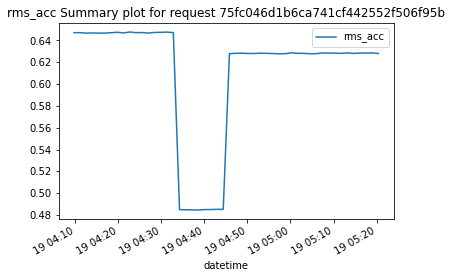

''

In [27]:
kpi_results_parsed.plot()

All these functions are available for the ModeId feature as well.
We proceed to repeat the same procedure for this other feature.

We begin by parsing the results.
In this particular case, we need to define the unit of time to perform the epoch conversion to datetime.
The default unit is milliseconds, but we need seconds now.
The timezone can also be defined, to increase the precision of these results.

In [28]:
mode_results_parsed = analysis_classes.parse_results(mode_results, t_unit="s")

First, we generate the pandas dataframe of ModeId results.

In [29]:
df_mode = mode_results_parsed.to_df()
df_mode.head()

,timestamps,labels,uncertain,mode_probability,datetime
0,1570186860,0,False,0.939155,2019-10-04 11:01:00+00:00
1,1570273260,0,False,0.872610,2019-10-05 11:01:00+00:00
2,1570359660,0,False,0.982989,2019-10-06 11:01:00+00:00
3,1570446060,0,False,0.996053,2019-10-07 11:01:00+00:00
4,1570532460,0,False,0.921091,2019-10-08 11:01:00+00:00


From the results, we can see that the ModeId feature provides a mode label for each timestamp, together with a boolean
describing the certainty around this mode label and its probability.


We can also request to display a summary of the results.

In [30]:
mode_results_parsed.summary()

=== ModeId ===
request_id 09fa086e2bcf4d25b2ad39a442d2c5ad
from 20191004-11:01.00 to 20191122-12:01.00

Labels
+----------+----------+-----------+--------------------+------------+
|   labels |   counts |   portion |   mode_probability |   datetime |
|----------+----------+-----------+--------------------+------------|
|        0 |       17 |        34 |                 17 |         17 |
|        1 |        8 |        16 |                  8 |          8 |
|        2 |       25 |        50 |                 25 |         25 |
+----------+----------+-----------+--------------------+------------+

Lables & uncertain labels
+------------+-----------+--------------------+------------+----------+
|            |   portion |   mode_probability |   datetime |   counts |
|------------+-----------+--------------------+------------+----------|
| (0, False) |        34 |                 17 |         17 |       17 |
| (1, False) |        16 |                  8 |          8 |        8 |
| (2, False)

[        counts  portion  mode_probability  datetime
 labels                                             
 0           17     34.0                17        17
 1            8     16.0                 8         8
 2           25     50.0                25        25,
                   portion  mode_probability  datetime  counts
 labels uncertain                                             
 0      False         34.0                17        17      17
 1      False         16.0                 8         8       8
 2      False         50.0                25        25      25,
    modes  emerging_time  max_prob_time  max_probability  \
 0      0     1570186860     1570446060         0.996053   
 1      1     1571655660     1572264060         0.997885   
 2      2     1572350460     1573646460         0.989592   
 
                    datetime  
 0 2019-10-04 11:01:00+00:00  
 1 2019-10-21 11:01:00+00:00  
 2 2019-10-29 12:01:00+00:00  ]

The summary of the results describes the number of timestamps for each mode and how many of these timestamps are uncertain.
Uncertain areas appear as a gray rectangle above the corresponding periods in the modes plot.

In addition, it provides information on the emerging modes.
Emerging modes describes the time (timestamp) each one of the modes first appeared.
This information can be useful to identify if a new mode is affecting or appearing in the asset.

Finally, we can generate a plot that displays display the different modes over time.

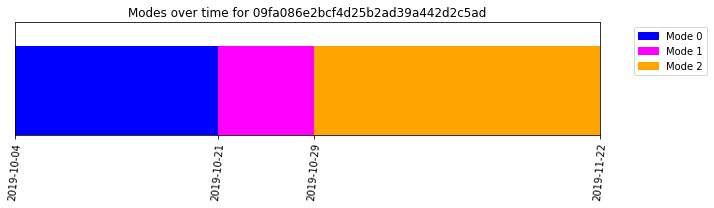

''

In [31]:
mode_results_parsed.plot()

Lastly, we can combine the information from the KPIDemo and ModeId features to display a boxplot of the "RMS" for each one of the operating modes.

First, we merge the "KPI" and "ModeId" dataframes.

In [32]:
df_u0001 =  pd.merge_asof(df_kpi, df_mode, on="timestamps")
df_u0001.head()

,timestamps,rms_acc,peak_acc,peak2peak_acc,variance_acc,crest_factor_acc,utilization_acc,dc_component_acc,datetime_x,labels,uncertain,mode_probability,datetime_y
0,1570186860,0.647094,2.686565,5.313293,0.418730,4.151739,1,-0.140239,1970-01-19 04:09:46.860000+00:00,0,False,0.939155,2019-10-04 11:01:00+00:00
1,1570273260,0.647131,2.691755,5.367004,0.418778,4.159523,1,-0.140425,1970-01-19 04:11:13.260000+00:00,0,False,0.872610,2019-10-05 11:01:00+00:00
2,1570359660,0.646627,2.715255,5.414856,0.418126,4.199108,1,-0.140243,1970-01-19 04:12:39.660000+00:00,0,False,0.982989,2019-10-06 11:01:00+00:00
3,1570446060,0.646881,2.685151,5.351562,0.418455,4.150921,1,-0.140351,1970-01-19 04:14:06.060000+00:00,0,False,0.996053,2019-10-07 11:01:00+00:00
4,1570532460,0.646649,2.726611,5.395325,0.418155,4.216521,1,-0.140429,1970-01-19 04:15:32.460000+00:00,0,False,0.921091,2019-10-08 11:01:00+00:00


The MVG library provides additional visualization functions that can help towards this goal.
Thus, we import the visualization module

In [33]:
from mvg import plotting

Now, we can proceed to plot the boxplot.

/home/oskar/viking_unix/mvg/env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


<AxesSubplot:title={'center':'Boxplot for u0001'}, xlabel='Modes', ylabel='rms_acc'>

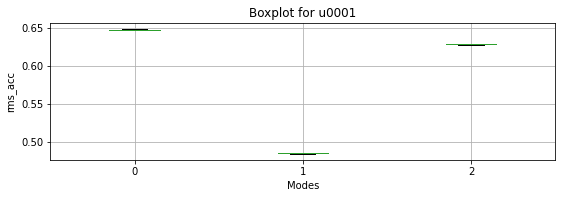

In [36]:
plotting.modes_boxplot(df_u0001, "rms_acc", SOURCE_ID)

Here we conclude our brief overview to begin using the MultiViz Analytics Engine (MVG) Library.